In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

import json
from glob import glob
import wandb
import os
import pandas as pd

In [105]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [115]:
os.makedirs('./assets',exist_ok=True)

# Figure

In [62]:
api = wandb.Api()

runs = api.runs('Normalization Test')

In [101]:
df_history = pd.DataFrame()

for run in runs:
    df = run.history()
    df['model'] = run.config['EXP_NAME']
    df['dataname'] = run.config['DATASET']['dataname']
    
    df_history = pd.concat([df_history, df], axis=0)

df_history.index = range(len(df_history))

name_map = {
    'resnet18'    : 'ResNet18',
    'resnet50'    : 'ResNet50',
    'densenet121' : 'DenseNet121',
    'densenet161' : 'DenseNet161'
}

def model_mapping(x: str, name_map: dict) -> str:
    name_map = {
        'resnet18'    : 'ResNet18',
        'resnet50'    : 'ResNet50',
        'densenet121' : 'DenseNet121',
        'densenet161' : 'DenseNet161'
    }
    
    name = x.split('-')[0]
    x = x.replace(name, name_map[name])
    x = x.replace('-pretrained_set', ' (pretrained)')
    x = x.replace('-finetune_set', ' (finetune)')

    return x
    
df_history['model'] = df_history['model'].apply(lambda x: model_mapping(x, name_map))

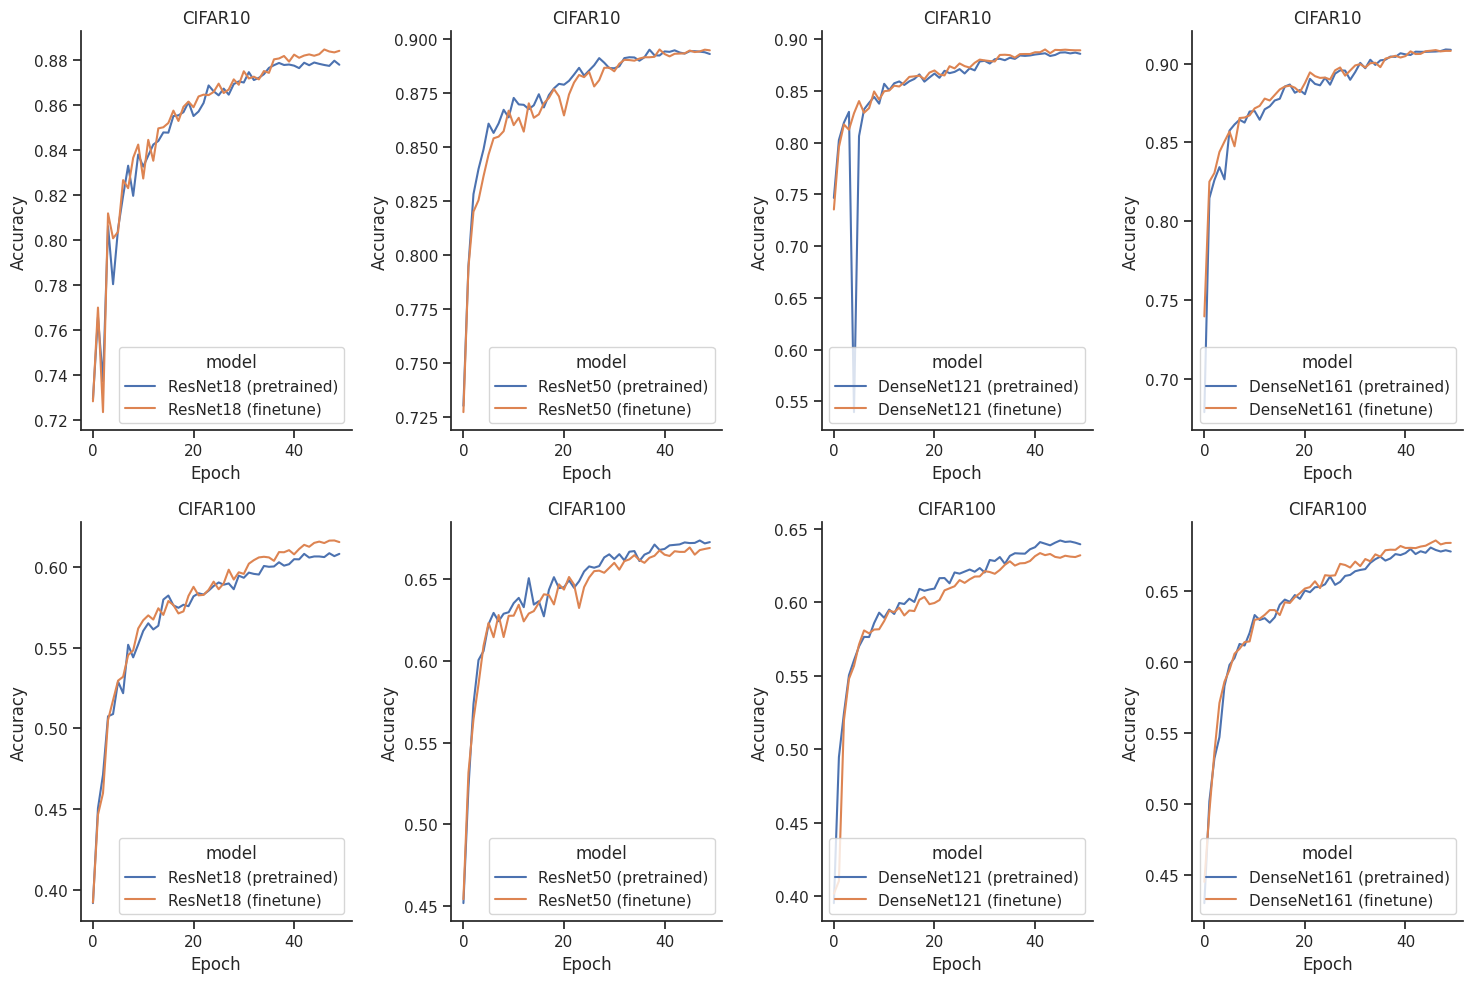

In [217]:
model_list = [(f'{m} (pretrained)',f'{m} (finetune)') for m in name_map.values()]
data_list = ['CIFAR10', 'CIFAR100']

fig, ax = plt.subplots(len(data_list), len(model_list), figsize=(15,10))

for r, d in enumerate(data_list):
    for c, m in enumerate(model_list):
        sns.lineplot(
            x    = '_step',
            y    = 'eval_acc',
            hue  = 'model',
            data = df_history[(df_history['dataname']==d) & (df_history['model'].isin(m))],
            ax   = ax[r, c]
        )
        ax[r, c].set_ylabel('Accuracy')
        ax[r, c].set_xlabel('Epoch')
        ax[r, c].set_title(d)

plt.tight_layout()
plt.savefig('./assets/figure1.jpg', dpi=300)

# Table

In [122]:
model_list = os.listdir('./saved_model/')
results_list = glob('./saved_model/*/*/best_results.json')

In [232]:
run.summary

{'_timestamp': 1682992801.4708264, 'train_loss': 0.04099873313680291, 'lr': 9.866357858642198e-07, '_step': 49, '_wandb': {'runtime': 429}, '_runtime': 430.54116344451904, 'eval_acc': 0.8841, 'eval_loss': 0.6087524250149727, 'train_acc': 0.98608}

In [233]:
# load results
dataname_list = []
model_list = []
acc_list = []

for r_path in results_list:
    dataname, model = r_path.split('/')[-3:-1]
    
    dataname_list.append(dataname)
    model_list.append(model)
    acc_list.append(json.load(open(r_path, 'r'))['best_acc'])

# make dataframe
df_results = pd.DataFrame({
    'dataname' : dataname_list,
    'expname'  : model_list,
    'acc'      : acc_list

})

# split expname into model and setting
df_results['model'] = df_results['expname'].apply(lambda x: x.split('-')[0])
df_results['setting'] = df_results['expname'].apply(lambda x: x.split('-')[1])

# change model name
df_results['model'] = df_results['model'].map(name_map)

# drop expname
df_results = df_results.drop('expname', axis=1)

In [234]:
df_results = df_results.set_index(['model','setting','dataname']).sort_index().unstack(level=2)

In [235]:
df_results.to_csv('./assets/table1.csv')

In [236]:
print(df_results.reset_index().to_markdown())

|    | ('model', '')   | ('setting', '')   |   ('acc', 'CIFAR10') |   ('acc', 'CIFAR100') |
|---:|:----------------|:------------------|---------------------:|----------------------:|
|  0 | DenseNet121     | finetune_set      |               0.8893 |                0.6321 |
|  1 | DenseNet121     | pretrained_set    |               0.8859 |                0.6396 |
|  2 | DenseNet161     | finetune_set      |               0.908  |                0.684  |
|  3 | DenseNet161     | pretrained_set    |               0.9087 |                0.6779 |
|  4 | ResNet18        | finetune_set      |               0.8841 |                0.6154 |
|  5 | ResNet18        | pretrained_set    |               0.8779 |                0.6081 |
|  6 | ResNet50        | finetune_set      |               0.8947 |                0.6693 |
|  7 | ResNet50        | pretrained_set    |               0.893  |                0.6729 |


In [207]:
from timm import create_model

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Desc

In [212]:
cifar10_params = []
cifar100_params = []

for m in name_map.keys():
    model = create_model(m, num_classes=10)
    cifar10_params.append(sum([p.numel() for p in model.parameters()]))
    
    model = create_model(m, num_classes=100)
    cifar100_params.append(sum([p.numel() for p in model.parameters()]))

In [214]:
model_desc =pd.DataFrame({
    'model'             : name_map.values(),
    '#Params (CIFAR10)' : cifar10_params,
    '#Params (CIFAR100)': cifar100_params
})

In [228]:
print(model_desc.to_markdown())

|    | model       |   #Params (CIFAR10) |   #Params (CIFAR100) |
|---:|:------------|--------------------:|---------------------:|
|  0 | ResNet18    |            11181642 |             11227812 |
|  1 | ResNet50    |            23528522 |             23712932 |
|  2 | DenseNet121 |             6964106 |              7056356 |
|  3 | DenseNet161 |            26494090 |             26692900 |
